<a href="https://colab.research.google.com/github/jpan2575/Homework9_Pan/blob/main/Homework9_Pan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


#Load data
from google.colab import drive
drive.mount('/content/drive')

filedir = '/content/drive/MyDrive/FWE458/'
fname = filedir + "SW_with_AOD.csv"

df = pd.read_csv(fname)

#Checking for missing values and outliers
print(df.isnull().sum())
print(df.describe())
df.head()


Mounted at /content/drive
SZA           0
AOD           0
COD           0
CLD_FRAC      0
UW            0
TO3           0
Pressure      0
BSA           0
WSA           0
SW_direct     0
SW_diffuse    0
dtype: int64
                SZA           AOD           COD      CLD_FRAC            UW  \
count  35224.000000  35224.000000  35224.000000  35224.000000  35224.000000   
mean      43.955300      0.607132      1.386743      0.146884      2.272496   
std       15.444956      0.561003      1.427229      0.136276      1.315785   
min        0.325058      0.001963      0.000031      0.000000      0.093588   
25%       32.476989      0.204275      0.290974      0.037539      1.172140   
50%       45.385958      0.399925      0.809864      0.095963      2.011255   
75%       56.807423      0.830358      2.163631      0.229764      3.218210   
max       69.999329      5.267975     16.270000      0.645196      6.701678   

                TO3      Pressure           BSA           WSA     SW_dire

,SZA,AOD,COD,CLD_FRAC,UW,TO3,Pressure,BSA,WSA,SW_direct,SW_diffuse
0,24.936783,1.172892,2.440000,0.286546,2.021502,311.419861,959.085083,0.162,0.193,467.191650,300.820007
1,34.865055,1.626954,4.630000,0.468832,4.859887,308.713379,968.427551,0.155,0.169,264.900024,385.293335
2,27.330978,1.095007,2.030000,0.301414,5.278558,293.322052,988.040588,0.136,0.149,313.553314,321.538361
3,20.361732,1.126541,5.500000,0.377019,4.856422,321.498199,977.610229,0.156,0.179,143.902298,501.073639
4,13.433228,0.725452,0.736076,0.075378,0.644262,295.448975,882.321411,0.188,0.212,957.331665,79.003334


<Figure size 1500x1500 with 0 Axes>

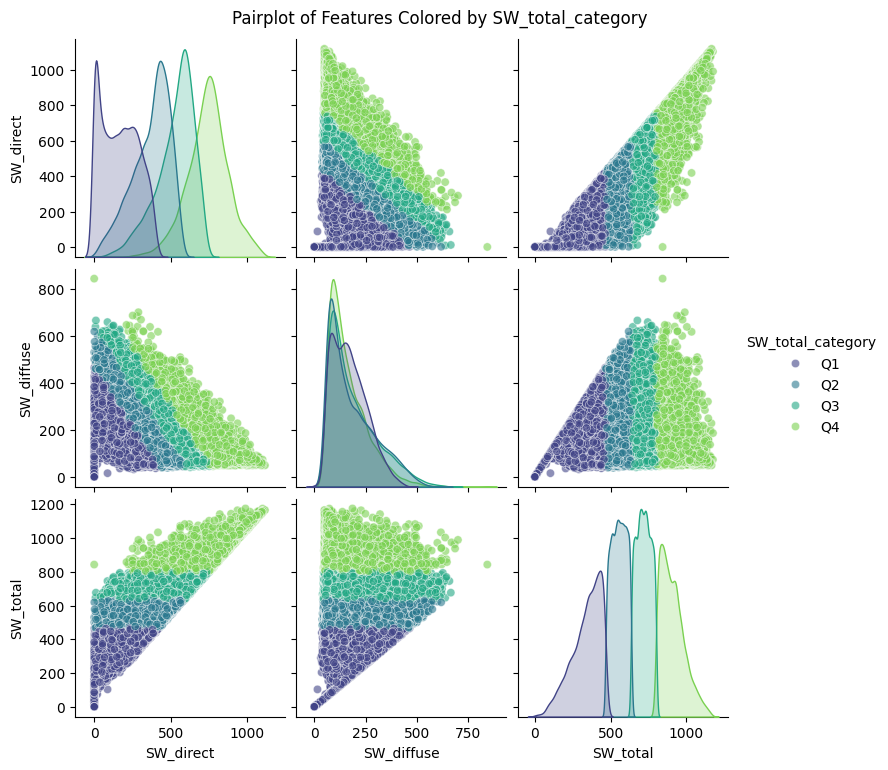

In [ ]:
#Create New Column
df['SW_total'] = df['SW_direct'] + df['SW_diffuse']

#Labels
quartiles = df['SW_total'].quantile([0.25, 0.5, 0.75]).values
labels = ['Q1', 'Q2', 'Q3', 'Q4']
df['SW_total_category'] = pd.cut(df['SW_total'],
bins=[-np.inf, quartiles[0], quartiles[1], quartiles[2], np.inf],
labels=labels)

#Plot
plot_cols = ['SW_direct', 'SW_diffuse', 'SW_total']
plt.figure(figsize=(15, 15))
sns.pairplot(df[plot_cols + ['SW_total_category']],
             hue='SW_total_category',
             palette='viridis',
             plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot of Features Colored by SW_total_category", y=1.02)
plt.show()


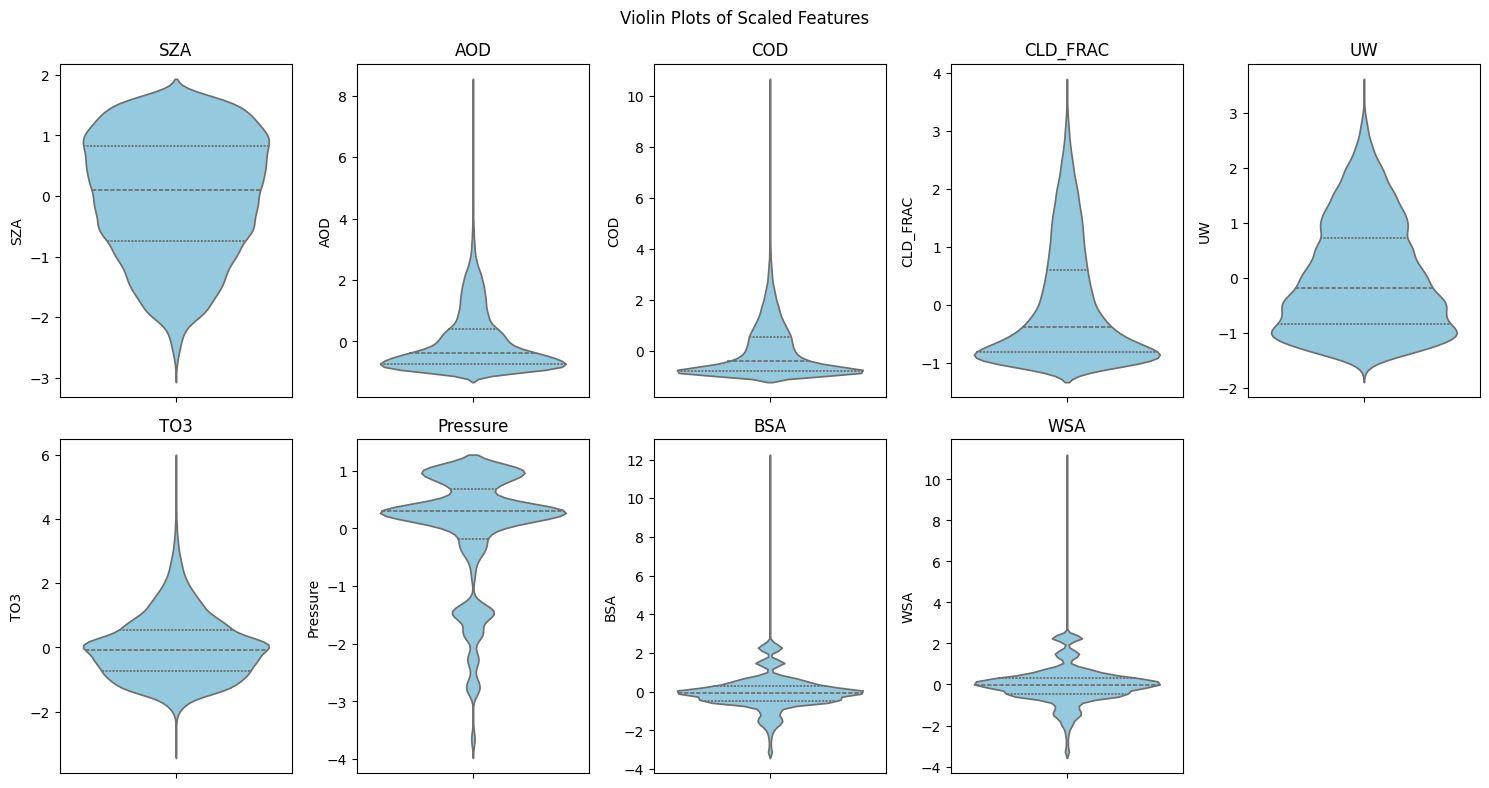

In [ ]:
# Scale the features
numeric_cols = df.select_dtypes(include=[np.number]).columns
input_features = [col for col in numeric_cols if col not in ['SW_direct', 'SW_diffuse', 'SW_total']]
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[input_features] = scaler.fit_transform(df[input_features])

plt.figure(figsize=(15, 8))
n_cols = 5
n_rows = 2

#Plot
for i, feature in enumerate(input_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(data=df_scaled, y=feature, color='skyblue', inner='quartile')
    plt.title(feature)


plt.suptitle("Violin Plots of Scaled Features")
plt.tight_layout()
plt.show()

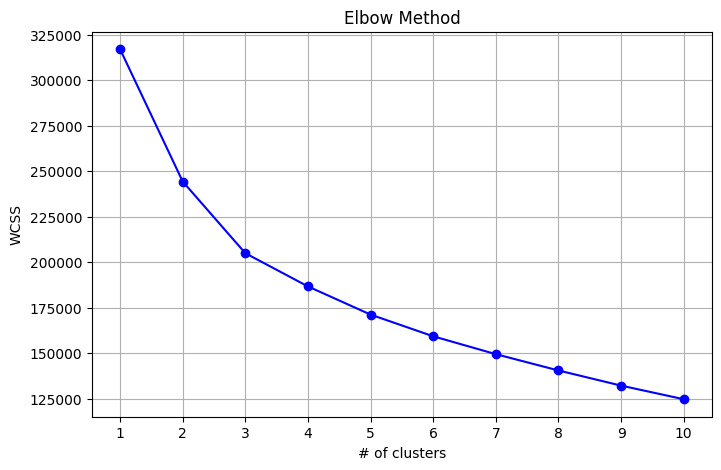

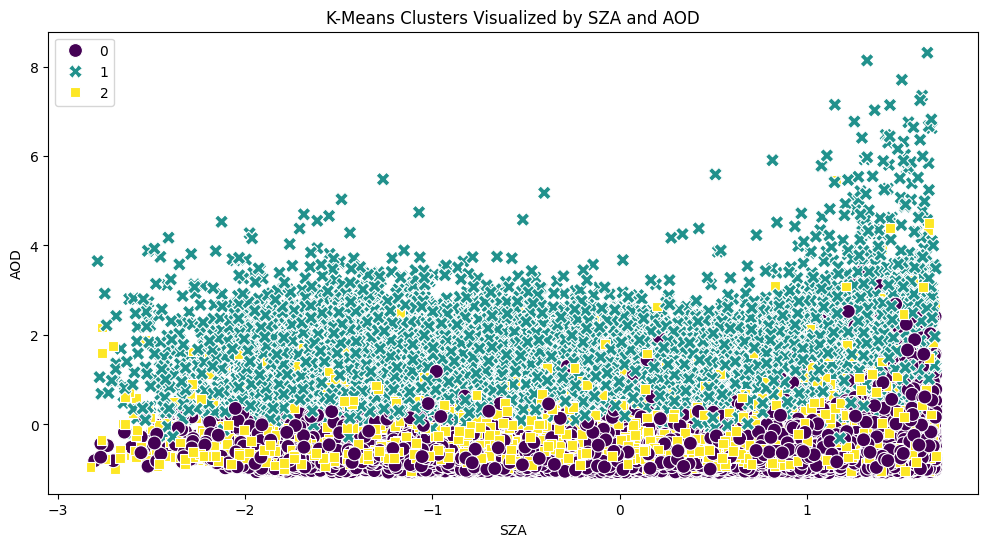

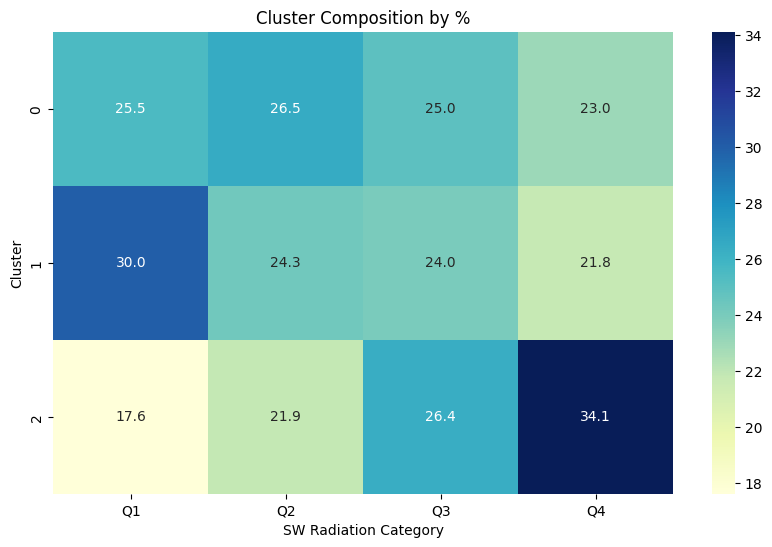

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Scalar
scaler = StandardScaler()
X = scaler.fit_transform(df[input_features])

#Determine optimal number of clusters using Elbow Method
wcss = []
max_clusters = 10

for k in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_clusters+1), wcss, 'bo-')
plt.xlabel('# of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.xticks(range(1, max_clusters+1))
plt.grid(True)
plt.show()

#Perform K-Means
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
df_scaled['Cluster'] = clusters

#Visualize clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_scaled, x='SZA', y='AOD', hue='Cluster',
                palette='viridis', style='Cluster', s=100)
plt.title(f'K-Means Clusters Visualized by SZA and AOD')
plt.legend()
plt.show()

#Analyze cluster alignment with heatmap
ct = pd.crosstab(df_scaled['Cluster'], df_scaled['SW_total_category'],
                 normalize='index') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Cluster Composition by %')
plt.ylabel('Cluster')
plt.xlabel('SW Radiation Category')
plt.show()

In [ ]:
cluster_summary = df_scaled.groupby('Cluster')[input_features].mean().T
print(cluster_summary)
'''
The clustering in the graph seperates quite cleanly and we can surmise that the clustering worked with some strong seperation.
Based on the summary, we find that there is a higher proportion of AOD in cluster 1 relative to cluster 0 and 2.
This may be indicative of broader trends within the data or that the bins have different characteristics.
'''

Cluster            0           1           2
SZA        45.965640   39.416304   44.230929
AOD         0.331077    1.345340    0.428851
COD         0.706878    3.272268    0.865227
CLD_FRAC    0.081797    0.339249    0.082473
UW          2.429328    2.824157    1.187209
TO3       300.976776  301.136270  281.014392
Pressure  979.547780  963.185282  899.266356
BSA         0.146439    0.144559    0.217919
WSA         0.158716    0.158528    0.230962


'\nThe clustering in the graph seperates quite cleanly and we can surmise that the clustering worked with some strong seperation. \nBased on the summary, we find that there is a higher proportion of AOD in cluster 1 relative to cluster 0 and 2.\nThis may be indicative of broader trends within the data \n'

In [ ]:
'''
As for the solar radiation categories, we can take a look at the heatmap to ascertain categories. We find that as cluster 0 it shows mostly
equal spread. For cluster 1 we see concentrations in lower radiation. For cluster 3 we see concentrations in higher radiation. We might be able
to conclude then that high radiation solar days has a distinctive effect on the distribution of the data for instance the impact of sunny days
versus that of cloudy days.
'''

'\nAs for the solar radiation categories, we can take a look at the heatmap to ascertain categories. We find that as cluster 0 it shows mostly \nequal spread. For cluster 1 we see concentrations in lower radiation. For cluster 3 we see concentrations in higher radiation. We might be able\nto conclude then that high radiation solar days has a distinctive effect on the distribution of the data for instance the impact of sunny days\nversus that of cloudy days.\n'

In [ ]:
from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = df_scaled[input_features]
y = df_scaled['SW_total']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train
dtree = DecisionTreeRegressor(random_state=42)
dtree.fit(X_train, y_train)

# Predictions
y_pred_dtree = dtree.predict(X_test)

# Metrics
rmse_dtree = np.sqrt(mean_squared_error(y_test, y_pred_dtree))
r2_dtree = r2_score(y_test, y_pred_dtree)

print('Decision Tree:')
print(f"RMSE: {rmse_dtree:.2f}")
print(f"R²: {r2_dtree:.2f}")

Decision Tree:
RMSE: 139.09
R²: 0.61


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print('Random Forest:')
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")


Random Forest:
RMSE: 99.05
R²: 0.80


In [ ]:
'''
We find that random forest does better due to a lower RMSE and comes out with a high r squared value which indicates a stronger realationship.
Random forest is better here as it mitigates overfitting by averaging out multiple trees and predicting the outcome via the ensemble method.
This helps generalize the data to a much higher standard than a singular decision tree ever could.
'''


'\nWe find that random forest does better due to a lower RMSE and comes out with a high r squared value which indicates a stronger realationship.\nRandom forest is better here as it mitigates overfitting by averaging out multiple trees and predicting the outcome via the ensemble method.\nThis helps generalize the data to a much higher standard than a singular decision tree ever could.\n'

KNN Classifier:
Accuracy: 0.68
Precision: 0.68
Recall: 0.68


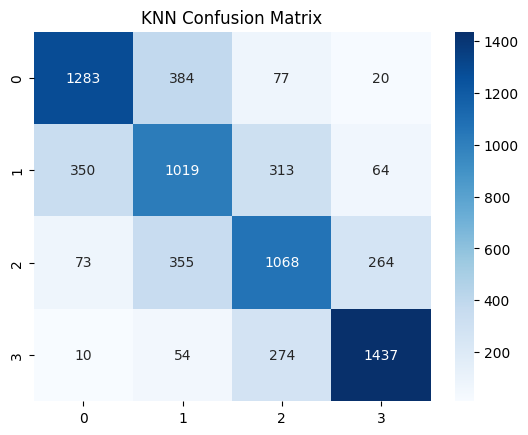

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

#Labels
quartiles = df['SW_total'].quantile([0.25, 0.5, 0.75]).values
labels = ['Q1', 'Q2', 'Q3', 'Q4']
df['SW_total_category'] = pd.cut(df['SW_total'],
bins=[-np.inf, quartiles[0], quartiles[1], quartiles[2], np.inf],
labels=labels)

y = df['SW_total_category']

#Train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Initialize and train
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions
y_pred_knn = knn.predict(X_test)

# Metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')

print("KNN Classifier:")
print(f"Accuracy: {accuracy_knn:.2f}")
print(f"Precision: {precision_knn:.2f}")
print(f"Recall: {recall_knn:.2f}")

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.show()


Gaussian Naive Bayes:
Accuracy: 0.66
Precision: 0.66
Recall: 0.66


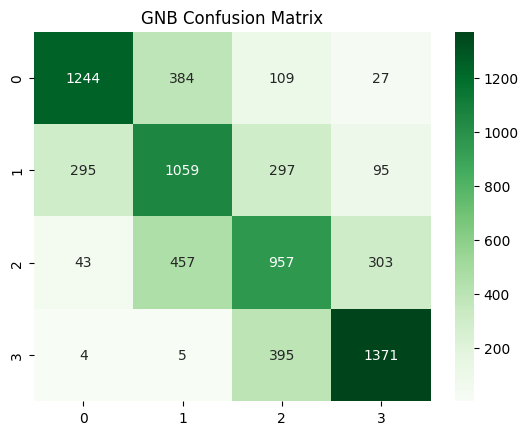

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predictions
y_pred_gnb = gnb.predict(X_test)

# Metrics
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
precision_gnb = precision_score(y_test, y_pred_gnb, average='weighted')
recall_gnb = recall_score(y_test, y_pred_gnb, average='weighted')

print("GNB:")
print(f"Accuracy: {accuracy_gnb:.2f}")
print(f"Precision: {precision_gnb:.2f}")
print(f"Recall: {recall_gnb:.2f}")

# Confusion Matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Greens')
plt.title('GNB Confusion Matrix')
plt.show()

In [ ]:
'''
KNN appears slightly better and is more accurate and percise based on our analysis. It attempts to compute the local probability based upon
classifers which may or may not be indepedent. GBN on the other hand assumes a couple of naive assumptions including that there are no
preexisting relationships within the data which is likely not true as AOD and SZA appears to be closely correlated
'''


'\nKNN appears slightly better and is more accurate and percise based on our analysis. It attempts to compute the local probability based upon\nclassifers which may or may not be indepedent. GBN on the other hand assumes a couple of naive assumptions including that there are no\npreexisting relationships within the data which is likely not true as AOD and SZA appears to be closely correlated\n'

In [ ]:
'''
The inputs Aerosol Optical Depth (AOD) and Solar Zenith Angle (SZA) are the most impactful here as randomforest shows us.
AOD can reduce radiation due to atmospheric factors, while high SZA (sun lower in the sky) decreases irradiance. Several other factors
like cloud cover appear to have smaller effects.

For clustering we see that high AOD is often associated with low radiation and vice versa. High AOD likely indicate cloudy or overcast days.
Meanwhile low AOD would probably be sunny days. Similar associations are found in SZA We can look at other analysis like KNN to see that
the clustering looks to be relatively accurate as well as it assumes no anomolies in distribution.

For continous samples we can use random forest regression as a first line method as the classifer
worked pretty well. If that doesn't work then KNN regression should be a
good backup method. These two appear to be the most accurate as well as relatively simple to utilize.
'''
